In [8]:
import cv2
import gdown
import matplotlib.pyplot as plt


# Import Videos

In [2]:
base_url = 'https://drive.google.com/uc?id='
book_video = base_url + '12-v0UI1OjLI3wxVP1VPfRBODtNplfIIj'
panda_video = base_url + '1te5I3FPBQrGtb1__DON8_cFLD1FDJ_yx'
book_cover_photo = base_url + '1aIbGkm6uCsZUfNhc1e9bk-hMMWZ1-HRf'
gdown.download(book_video)
gdown.download(panda_video)
gdown.download(book_cover_photo)

Downloading...
From: https://drive.google.com/uc?id=12-v0UI1OjLI3wxVP1VPfRBODtNplfIIj
To: /content/book.mov
100%|██████████| 28.5M/28.5M [00:00<00:00, 180MB/s]
Downloading...
From: https://drive.google.com/uc?id=1te5I3FPBQrGtb1__DON8_cFLD1FDJ_yx
To: /content/source.mov
100%|██████████| 6.29M/6.29M [00:00<00:00, 120MB/s]
Downloading...
From: https://drive.google.com/uc?id=1aIbGkm6uCsZUfNhc1e9bk-hMMWZ1-HRf
To: /content/cover.jpg
100%|██████████| 117k/117k [00:00<00:00, 56.1MB/s]


'cover.jpg'

# General Functions

In [9]:
def display_image(image, title):
    plt.figure(figsize=(8, 8))
    if len(image.shape) == 3:  # Color image
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        plt.imshow(image)
    else:  # Grayscale image
        plt.imshow(image, cmap='gray')
    plt.title(title)
    plt.axis('off')
    plt.show()

# Getting Correspondences

## Extract and Save Frame

In [5]:
def get_first_frame(video_path):
    '''
    Input: .mov file path
    Output: first frame of video as numpy array
    '''
    cap = cv2.VideoCapture(video_path)
    ret, frame = cap.read()
    cap.release()
    return frame



book_frame = get_first_frame('/content/book.mov')
cv2.imwrite('book_frame.jpg', book_frame) # save first frame as jpg


<class 'numpy.ndarray'>


## Get SIFT Keypoints

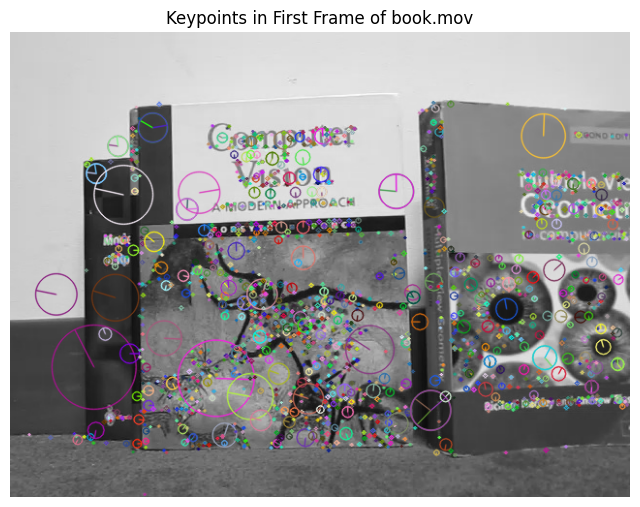

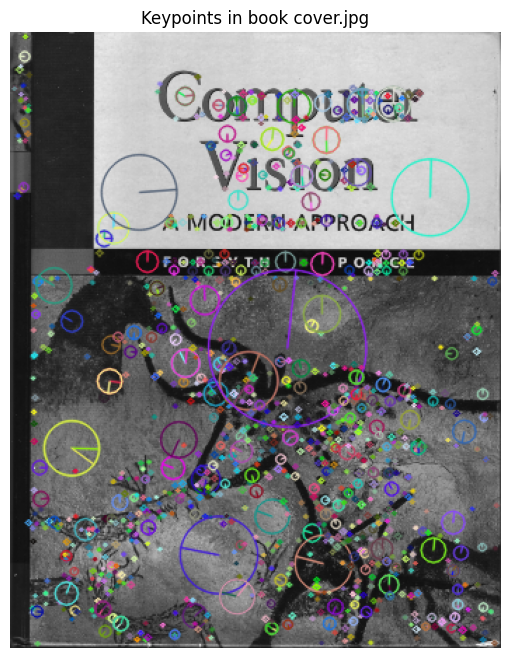

In [10]:
book_frame = cv2.imread('/content/book_frame.jpg')
book_cover = cv2.imread('/content/cover.jpg')

# Convert to grayscale
gray_book_frame = cv2.cvtColor(book_frame, cv2.COLOR_BGR2GRAY)
gray_book_cover = cv2.cvtColor(book_cover, cv2.COLOR_BGR2GRAY)


# Initialize SIFT detector
sift = cv2.SIFT_create()


# Detect keypoints and compute descriptors
keypoints_frame, descriptors_frame = sift.detectAndCompute(gray_book_frame, None)
keypoints_book, descriptors_book = sift.detectAndCompute(gray_book_cover, None)

# Draw keypoints on the images
frame_with_keypoints = cv2.drawKeypoints(
    gray_book_frame, keypoints_frame, None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
book_with_keypoints = cv2.drawKeypoints(
    gray_book_cover, keypoints_book, None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)


# Display the images with keypoints
display_image(frame_with_keypoints, "Keypoints in First Frame of book.mov")
display_image(book_with_keypoints, "Keypoints in book cover.jpg")

## Match Keypoints

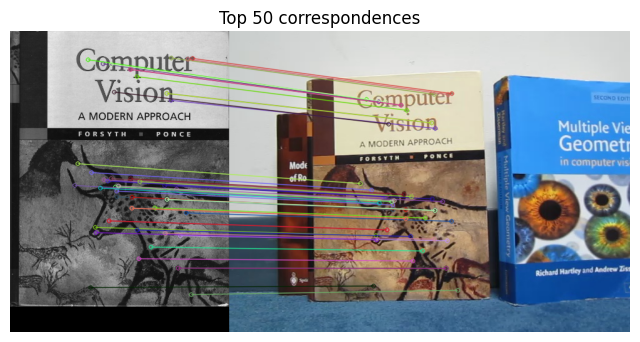

In [14]:
# Initialize Brute Force Matcher
bf = cv2.BFMatcher()

# Perform KNN matching with k=2
matches = bf.knnMatch(descriptors_book, descriptors_frame, k=2)


# Apply ratio test to filter good matches
ratio_thresh = 0.3
good_matches = []
for m, n in matches:
    if m.distance < ratio_thresh * n.distance:
        good_matches.append(m)

# Sort matches based on distance (best matches first)
good_matches = sorted(good_matches, key=lambda x: x.distance)

# Choose top 50 correspondences
top_matches = good_matches[:50]

# Plotting the matches
matched_image = cv2.drawMatches(
    book_cover, keypoints_book,
    book_frame, keypoints_frame,
    top_matches, None,
    flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS
)


display_image(matched_image, "Top 50 correspondences")